In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# df = pd.read_csv('C:/Saravana/Data/Raw/2016.log')
df = pd.read_pickle('C:/Saravana/Data/Raw/export-cleansed-4851f054c66579780503d70880731802.pkl.bz2')
display(df.head())

,IMP_ID,GJ,IMPORT,MUFO_REFERENZ_N,BARCODE_NR,VERANST_SEGMENT,REKLA_JN,VG_DATUM_VON,VG_ORT,VG_RAUM,...,VERANST_ORT,NUTZLIZNEHM_GESCHAEFTSZEICHEN,NUTZLIZNEHM_NAME,NUTZLIZNEHM_VORNAME,NUTZLIZNEHM_STRASSE,NUTZLIZNEHM_PLZ,NUTZLIZNEHM_ORT,LOCATION,BAND,PROMOTER
ID,,,,,,,,,,,,,,,,,,,,,
9938765,24643,2016,ABRE U INKA 2016,NaN,5027961220,4.0,NONRekla,2014-02-09,LISBERG,TURNHALLE SV RW LISBERG,...,WALSDORF,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,LISBERG TURNHALLE SV RW LISBERG,NaN,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194
9938766,24643,2016,ABRE U INKA 2016,NaN,5027961235,6.0,NONRekla,2014-02-08,LISBERG,TURNHALLE SV RW LISBERG,...,WALSDORF,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,LISBERG TURNHALLE SV RW LISBERG,DAS BOEHMISCHE FEUER,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194
9938851,24643,2016,ABRE U INKA 2016,NaN,5044481411,3.0,NONRekla,2014-03-15,MUENCHEN,WERNER-VON-SIEMENS-SCHULZENTRUM,...,MUENCHEN,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,MUENCHEN WERNER-VON-SIEMENS-SCHULZENTRUM,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...
9938852,24643,2016,ABRE U INKA 2016,NaN,5044481427,2.0,NONRekla,2014-03-14,MUENCHEN,PFARRHEIM UND KIRCHE,...,MUENCHEN,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,MUENCHEN PFARRHEIM UND KIRCHE,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...
9938853,24643,2016,ABRE U INKA 2016,NaN,5044481469,2.0,NONRekla,2014-02-09,GRAFENRHEINFELD,KULTURHALLE GRAFENRHEINFELD,...,WERNECK,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,GRAFENRHEINFELD KULTURHALLE GRAFENRHEINFELD,NaN,MUSIKVEREIN WERNECK E.V 97440


In [12]:
df.VERANST_SEGMENT.unique()

array([ 4.,  6.,  3.,  2.,  5.,  7.,  8., 10.,  9., 11., 12.])

In [23]:
df.VG_RAUM.unique()

['TURNHALLE SV RW LISBERG', 'WERNER-VON-SIEMENS-SCHULZENTRUM', 'PFARRHEIM UND KIRCHE', 'KULTURHALLE GRAFENRHEINFELD', 'VEREINSHEIM TSV FRIESENRIED', ..., 'LEERSTAND 28.09.20', 'QUARTIERZENTRUM B26', 'GOETHE-INSTITUTE AUSLAND', 'COCKTAILBAR SUESS WAR GESTERN', 'TRAUMPALAST BIBERACH']
Length: 129572
Categories (129571, object): ['" DE SMUGGLER " CELTIC PUB', '" DORNSPACHHAUS " HISTOR. WIRTSHAUS', '" DORNSPACHHAUS " HISTORISCHES WIRTSHAUS', '" FIZZ " FESTE FEIERN', ..., 'ZWOENITZ', 'ZWOGGEL', 'ZWOTA', 'ZYCKO']

In [24]:
df.VG_ORT.unique()

['LISBERG', 'MUENCHEN', 'GRAFENRHEINFELD', 'FRIESENRIED', 'HEIMENKIRCH', ..., 'KLEIN BARKAU', 'SCHLOEN', 'PEENEHAGEN', 'GROSSFRIESEN', 'MAROTH']
Length: 12090
Categories (12089, object): ['191211800 - GOSPELCHOR SWEET CHARIOT', 'AACH', 'AACHEN', 'AALEN', ..., 'ZWINGENBERG', 'ZWOCHAU', 'ZWOENITZ', 'ZWOTA']

In [4]:
# Filter segment 2(0-50 euros) & segment 3(50-100 euros) 

lowerclaim_df = df.query('VERANST_SEGMENT <= 3')
len(lowerclaim_df.index)

2029523

In [34]:
display(lowerclaim_df.columns)
# Count NaN values for each column in the dataframe
display(lowerclaim_df.isna().sum())

Index(['IMP_ID', 'GJ', 'IMPORT', 'MUFO_REFERENZ_N', 'BARCODE_NR',
       'VERANST_SEGMENT', 'REKLA_JN', 'VG_DATUM_VON', 'VG_ORT', 'VG_RAUM',
       'NUTZFALL', 'NUTZFALL_RAUM', 'MUSIKLEITER_NAME', 'KAPELLE_NAME',
       'TARIF_NR', 'TARIF_BEZ', 'NUTZFALL_NR', 'VG_INKASSO', 'INKASSO_NETTO',
       'INKASSO_BRUTTO', 'VERANST_GESCHAEFTSZEICHEN', 'VERANST_NAME',
       'VERANST_STRASSE', 'VERANST_PLZ', 'VERANST_ORT',
       'NUTZLIZNEHM_GESCHAEFTSZEICHEN', 'NUTZLIZNEHM_NAME',
       'NUTZLIZNEHM_VORNAME', 'NUTZLIZNEHM_STRASSE', 'NUTZLIZNEHM_PLZ',
       'NUTZLIZNEHM_ORT', 'LOCATION', 'BAND', 'PROMOTER'],
      dtype='object')

IMP_ID                                 0
GJ                                     0
IMPORT                                 0
MUFO_REFERENZ_N                  1979319
BARCODE_NR                             0
VERANST_SEGMENT                        0
REKLA_JN                               0
VG_DATUM_VON                           0
VG_ORT                               146
VG_RAUM                               95
NUTZFALL                               0
NUTZFALL_RAUM                         95
MUSIKLEITER_NAME                 1306586
KAPELLE_NAME                      960942
TARIF_NR                               0
TARIF_BEZ                              0
NUTZFALL_NR                            0
VG_INKASSO                             0
INKASSO_NETTO                    2029521
INKASSO_BRUTTO                   2029521
VERANST_GESCHAEFTSZEICHEN              0
VERANST_NAME                         103
VERANST_STRASSE                    11578
VERANST_PLZ                          657
VERANST_ORT     

In [ ]:
IMP_ID                                 
GJ                               GeschaftsJahr      
IMPORT                                 
MUFO_REFERENZ_N                  
BARCODE_NR                             
VERANST_SEGMENT                  Event segment
REKLA_JN                         Reclamation 
VG_DATUM_VON                     Event Date
VG_ORT                           Event place
VG_RAUM                          Event room
NUTZFALL                         Use case
NUTZFALL_RAUM                    Use case Room
MUSIKLEITER_NAME                 Music Leader name
KAPELLE_NAME                     Chapel name
TARIF_NR                         Tariff Number
TARIF_BEZ                        Tariff Bez
NUTZFALL_NR                      Usecase Number
VG_INKASSO                       Event collection
INKASSO_NETTO                    Net-Collection
INKASSO_BRUTTO                   Gross-Collection
VERANST_GESCHAEFTSZEICHEN        Event business sign or mark 
VERANST_NAME                     Event name
VERANST_STRASSE                  Event street
VERANST_PLZ                      Event post code
VERANST_ORT                      Event place

# Nutzungs Lizenznehmer - someone who has got the license(Usage licence) for the music works
NUTZLIZNEHM_GESCHAEFTSZEICHEN    
NUTZLIZNEHM_NAME                 name of person who aquired usage license
NUTZLIZNEHM_VORNAME              surname of person who aquired usage license
NUTZLIZNEHM_STRASSE              street of person who aquired usage license
NUTZLIZNEHM_PLZ                  postcode of person who aquired usage license
NUTZLIZNEHM_ORT                  place of person who aquired usage license
LOCATION                         location
BAND                             band
PROMOTER                         promoter

In [50]:
print(lowerclaim_df['VG_INKASSO'].max())
print(lowerclaim_df['VG_INKASSO'].min())

409.7
0.04


Univariate Plotting - Distribution of the event collection in Euros

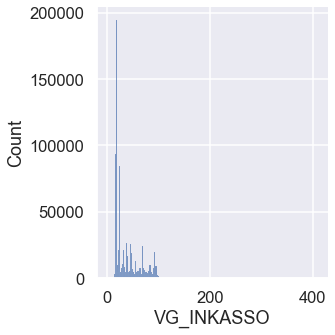

In [82]:
# kde - Kernel Density
sns.displot(lowerclaim_df['VG_INKASSO'], kde=False)
plt.show()

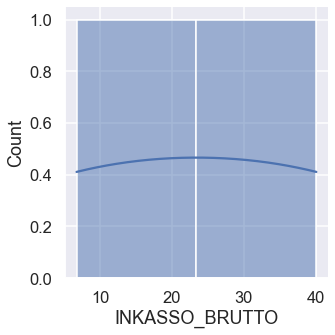

In [81]:
sns.displot(lowerclaim_df['INKASSO_BRUTTO'], kde=True)
plt.show()

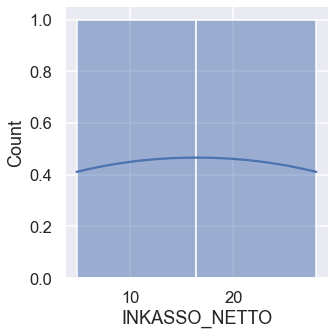

In [63]:
sns.displot(lowerclaim_df['INKASSO_NETTO'], kde=True)

In [65]:
lowerclaim_df['INKASSO_BRUTTO'].value_counts()

6.68     1
40.10    1
Name: INKASSO_BRUTTO, dtype: int64

In [66]:
lowerclaim_df['INKASSO_NETTO'].value_counts()

4.77     1
28.04    1
Name: INKASSO_NETTO, dtype: int64

In [67]:
lowerclaim_df['VG_INKASSO'].value_counts()

18.64    74521
23.05    64624
18.44    61478
18.84    54008
23.30    46425
         ...  
15.78        1
15.69        1
12.60        1
0.24         1
12.66        1
Name: VG_INKASSO, Length: 8697, dtype: int64

In [57]:
# Find the values seperated by comma
contains_comma = lowerclaim_df[lowerclaim_df['VG_ORT'].str.contains(',') == True]
non_comma_df = lowerclaim_df[lowerclaim_df['VG_ORT'].str.contains(',') == False]
print(len(contains_comma))
print(len(contains_comma['VG_ORT'].unique()))
print(contains_comma['VG_ORT'])
splitted_places = contains_comma['VG_ORT'].str.split(r",", expand=True)[0]
print(len(splitted_places.unique()))
print(splitted_places)
print("--------Non-commma-values--------")
print(len(non_comma_df))
print(len(non_comma_df['VG_ORT'].unique()))
non_splitted_places = non_comma_df['VG_ORT']
# splitted_places = contains_comma['VG_ORT'].str.split(r",", expand=True)[0]
# print("--------Splitted values--------")
place_df = pd.concat([non_splitted_places,splitted_places])
print(place_df)
print(len(place_df.unique()))


12509
244
ID
9940000            MUENSTER, WESTF
9940329             KERPEN, RHEINL
9944916      SALZWEDEL, HANSESTADT
9944920                DESSAU, ANH
9947304            STEINACH, THUER
                     ...          
13946625               ESSEN, RUHR
13947063    GREIFSWALD, HANSESTADT
13947064    GREIFSWALD, HANSESTADT
13947233    GREIFSWALD, HANSESTADT
13948526    GREIFSWALD, HANSESTADT
Name: VG_ORT, Length: 12509, dtype: category
Categories (12089, object): ['191211800 - GOSPELCHOR SWEET CHARIOT', 'AACH', 'AACHEN', 'AALEN', ..., 'ZWINGENBERG', 'ZWOCHAU', 'ZWOENITZ', 'ZWOTA']
240
ID
9940000       MUENSTER
9940329         KERPEN
9944916      SALZWEDEL
9944920         DESSAU
9947304       STEINACH
               ...    
13946625         ESSEN
13947063    GREIFSWALD
13947064    GREIFSWALD
13947233    GREIFSWALD
13948526    GREIFSWALD
Name: 0, Length: 12509, dtype: object
--------Non-commma-values--------
2016868
11355
ID
9938851            MUENCHEN
9938852            MUENCHEN
9938

In [ ]:
Group the places by the state
Find the missing places using the PLZ or using the VG_Raum

In [69]:
# There are only 2 values in the INKASSO_NETTO and INKASSO_BRUTTO
# There are no null values in VG_INKASSO
# Lowest value of VG_INKASSO is 0.04 and highest value is 409.7
# How could segment 2 (0 - 50 euros) and segment 3 (50-100 euros) would have high VG_INKASSO values?


2029523

In [78]:
lowerclaim_df[lowerclaim_df['VG_INKASSO']>400].head()

,IMP_ID,GJ,IMPORT,MUFO_REFERENZ_N,BARCODE_NR,VERANST_SEGMENT,REKLA_JN,VG_DATUM_VON,VG_ORT,VG_RAUM,...,VERANST_ORT,NUTZLIZNEHM_GESCHAEFTSZEICHEN,NUTZLIZNEHM_NAME,NUTZLIZNEHM_VORNAME,NUTZLIZNEHM_STRASSE,NUTZLIZNEHM_PLZ,NUTZLIZNEHM_ORT,LOCATION,BAND,PROMOTER
ID,,,,,,,,,,,,,,,,,,,,,
13771897,54243,2020,ABRE U INKA 2020,NaN,6668148285,2.0,NONRekla,2019-04-06,"NUERNBERG, MITTELFR","NUERNBERG, MITTELFR",...,NUERNBERG,0,NaN,NaN,NaN,NaN,NaN,"NUERNBERG, MITTELFR NUERNBERG, MITTELFR",OSZKAR BERTHOLINI,BRUECKENFESTIVAL E.V. E.V 90475
13771899,54243,2020,ABRE U INKA 2020,NaN,6668148270,2.0,NONRekla,2019-04-06,"NUERNBERG, MITTELFR","NUERNBERG, MITTELFR",...,NUERNBERG,0,NaN,NaN,NaN,NaN,NaN,"NUERNBERG, MITTELFR NUERNBERG, MITTELFR",ELENA STERI,BRUECKENFESTIVAL E.V. E.V 90475
13771900,54243,2020,ABRE U INKA 2020,NaN,6668148433,2.0,NONRekla,2019-04-06,"NUERNBERG, MITTELFR","NUERNBERG, MITTELFR",...,NUERNBERG,0,NaN,NaN,NaN,NaN,NaN,"NUERNBERG, MITTELFR NUERNBERG, MITTELFR",THE ELEPLANT CIRCUS,BRUECKENFESTIVAL E.V. E.V 90475
13771902,54243,2020,ABRE U INKA 2020,NaN,6668148304,2.0,NONRekla,2019-04-06,"NUERNBERG, MITTELFR","NUERNBERG, MITTELFR",...,NUERNBERG,0,NaN,NaN,NaN,NaN,NaN,"NUERNBERG, MITTELFR NUERNBERG, MITTELFR",SHE OWE,BRUECKENFESTIVAL E.V. E.V 90475
13771945,54243,2020,ABRE U INKA 2020,NaN,6707446156,2.0,NONRekla,2019-04-06,"NUERNBERG, MITTELFR","NUERNBERG, MITTELFR",...,NUERNBERG,0,NaN,NaN,NaN,NaN,NaN,"NUERNBERG, MITTELFR NUERNBERG, MITTELFR",BRICKWATER,BRUECKENFESTIVAL E.V. E.V 90475


Multivariate Analysis

(array([    0,     1,     2, ..., 12086, 12087, 12088]),
 [Text(0, 0, '191211800 - GOSPELCHOR SWEET CHARIOT'),
  Text(1, 0, 'AACH'),
  Text(2, 0, 'AACHEN'),
  Text(3, 0, 'AALEN'),
  Text(4, 0, 'AALEN, WUERTT'),
  Text(5, 0, 'AALEN-WALDHAUSEN'),
  Text(6, 0, 'AARBERGEN'),
  Text(7, 0, 'ABBENRODE'),
  Text(8, 0, 'ABENBERG'),
  Text(9, 0, 'ABENSBERG'),
  Text(10, 0, 'ABENTHEUER'),
  Text(11, 0, 'ABSBERG'),
  Text(12, 0, 'ABSTATT'),
  Text(13, 0, 'ABTGSMUEND-HOEHENSTADT'),
  Text(14, 0, 'ABTLOEBNITZ'),
  Text(15, 0, 'ABTSDORF B LUTHERSTADT'),
  Text(16, 0, 'ABTSGMUEND'),
  Text(17, 0, 'ABTSTEINACH'),
  Text(18, 0, 'ABTSWIND'),
  Text(19, 0, 'ACHBERG'),
  Text(20, 0, 'ACHERN'),
  Text(21, 0, 'ACHIM'),
  Text(22, 0, 'ACHSLACH'),
  Text(23, 0, 'ACHSTETTEN'),
  Text(24, 0, 'ACHTELSBACH'),
  Text(25, 0, 'ACHTRUP'),
  Text(26, 0, 'ADAMSDORF'),
  Text(27, 0, 'ADELBERG'),
  Text(28, 0, 'ADELEBSEN'),
  Text(29, 0, 'ADELHEIDSDORF'),
  Text(30, 0, 'ADELMANNSFELDEN'),
  Text(31, 0, 'ADELSCHLAG'),
  Te

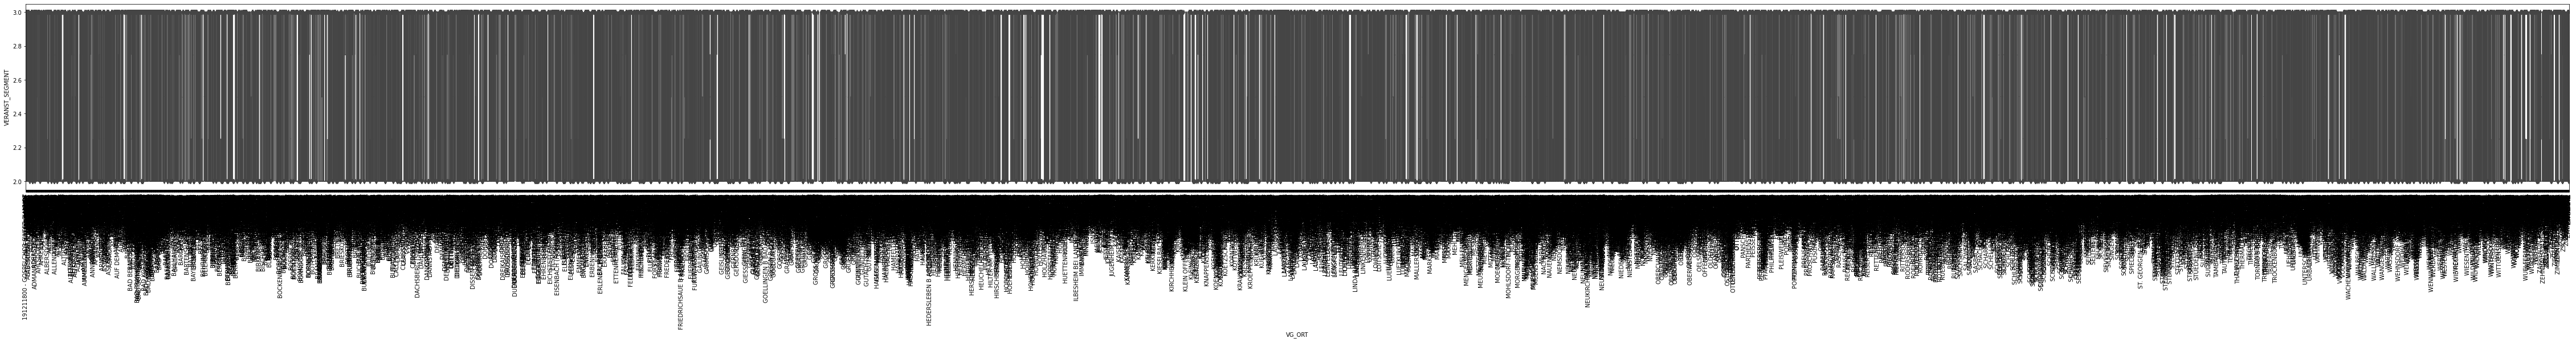

In [19]:
# Null values
# VG_ORT - 146
# VERANST_ORT  368
# VG_RAUM/LOCATION - 95
# VERANST_NAME/PROMOTER  103
# TARIF_BEZ  0
# BAND  943181
# KAPELLE_NAME 960942
# sns.barplot(x=lowerclaim_df['VG_ORT'], y=df['VERANST_SEGMENT'])
# plt.show()

#box plot Place/Customer Segment
data = pd.concat([lowerclaim_df['VG_ORT'], df['VERANST_SEGMENT']], axis=1)
f, ax = plt.subplots(figsize=(80, 6))
fig = sns.boxplot(x="VG_ORT", y="VERANST_SEGMENT", data=data)
plt.xticks(rotation=90)

(array([    0,     1,     2, ..., 10132, 10133, 10134]),
 [Text(0, 0, 'MUENCHEN'),
  Text(1, 0, 'WERNECK'),
  Text(2, 0, 'FRIESENRIED'),
  Text(3, 0, 'HEIMENKIRCH'),
  Text(4, 0, 'BAD KOETZTING'),
  Text(5, 0, 'ZENTING'),
  Text(6, 0, 'AYSTETTEN'),
  Text(7, 0, 'STULLN'),
  Text(8, 0, 'WALDSHUT-TIENGEN'),
  Text(9, 0, 'KARLSRUHE'),
  Text(10, 0, 'LANGENBRETTACH'),
  Text(11, 0, 'SCHWIEBERDINGEN'),
  Text(12, 0, 'JAGSTZELL'),
  Text(13, 0, 'RAVENSBURG'),
  Text(14, 0, 'WIPPERDORF'),
  Text(15, 0, 'MINDELHEIM'),
  Text(16, 0, 'DINGOLFING'),
  Text(17, 0, 'FRAUENAU'),
  Text(18, 0, 'KIRCHEHRENBACH'),
  Text(19, 0, 'FUERSTENZELL'),
  Text(20, 0, 'PALLING'),
  Text(21, 0, 'BAD KOHLGRUB'),
  Text(22, 0, 'HOECHBERG'),
  Text(23, 0, 'ROTHENBURG OB DER TAUBER'),
  Text(24, 0, 'BUCHLOE'),
  Text(25, 0, 'FUERSTENFELDBRUCK'),
  Text(26, 0, 'OLCHING'),
  Text(27, 0, 'AUGSBURG'),
  Text(28, 0, 'WUERZBURG'),
  Text(29, 0, 'ZELLINGEN'),
  Text(30, 0, 'TRIFTERN'),
  Text(31, 0, 'NEUMARKT-SANKT VEIT'),


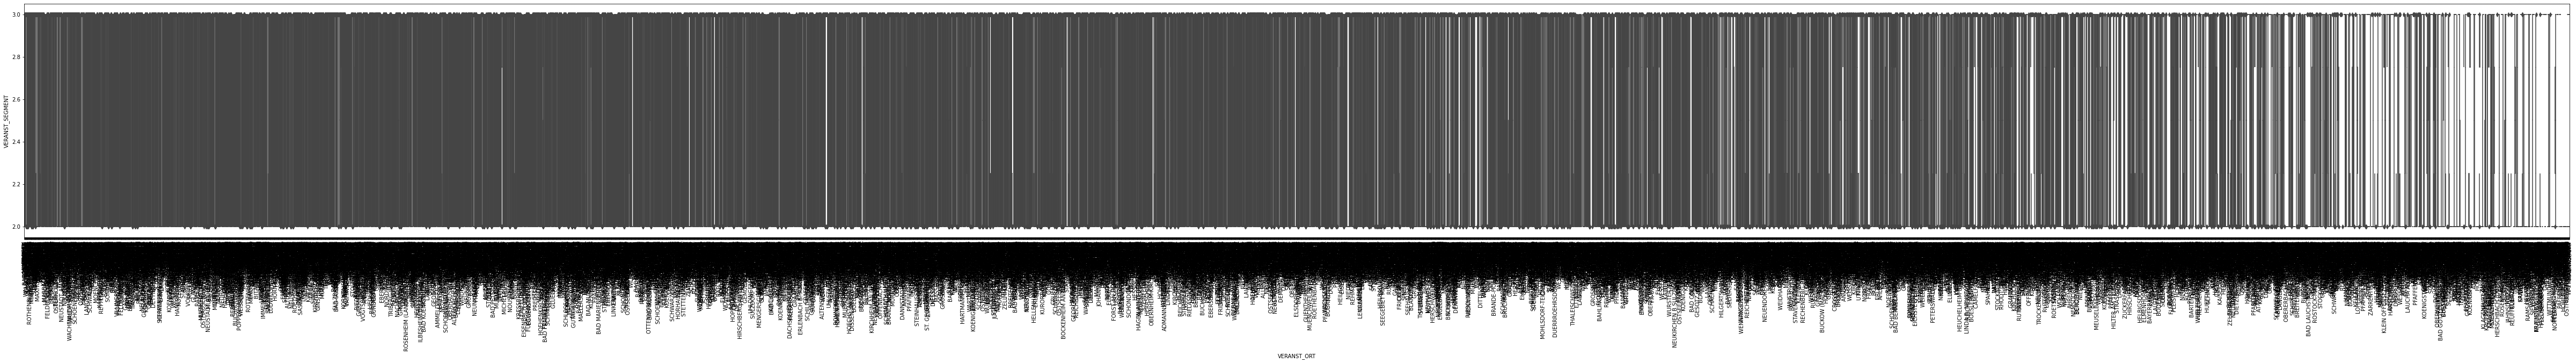

In [17]:
#box plot VERANST_ORT/Customer Segment
data = pd.concat([lowerclaim_df['VERANST_ORT'], df['VERANST_SEGMENT']], axis=1)
f, ax = plt.subplots(figsize=(85, 8))
fig = sns.boxplot(x="VERANST_ORT", y="VERANST_SEGMENT", data=data)
plt.xticks(rotation=90)

KeyboardInterrupt: 

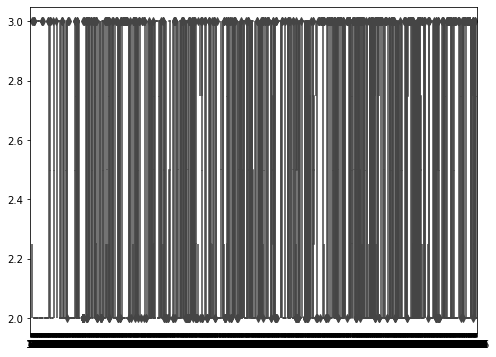

In [10]:
# sns.barplot(x=lowerclaim_df['VG_RAUM'], y=df['VERANST_SEGMENT'])
# plt.show()

#box plot Room/Customer Segment
data = pd.concat([lowerclaim_df['VG_RAUM'], df['VERANST_SEGMENT']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="VG_RAUM", y="VERANST_SEGMENT", data=data)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90]),
 [Text(0, 0, 'BM I. 1. / 2.'),
  Text(1, 0, 'BM I.1. BIS 25 MINUTEN'),
  Text(2, 0, 'CHORVERBAND KONZERT E-MUSIK MIT EINTRITTSGELD'),
  Text(3, 0, 'CHORVERBAND KONZERT E-MUSIK OHNE EINTRITTSGELD'),
  Text(4, 0, 'CHORVERBAND KONZERT U-MUSIK'),
  Text(5, 0, 'E (MUSIKER)'),
  Text(6, 0, 'E (TONTRAEGER)'),
  Text(7, 0, 'E HAERTEFALL MINDESTVERGUETUNG'),
  Text(8, 0, 'E HAERTEFALL REGELVERGUETUNG'),
  Text(9, 0, 'E HAERTEFALL REGELVERGUETUNG (5%)'),
  Text(10, 0, 'E HAERTEFALL REGELVERGUETUNG (7,5%)'),
  Text(11, 0, 'E-P'),
  Text(12, 0, 'KONZERT CHORVERBAENDE MIT EINTRITTSGELD (10%)'

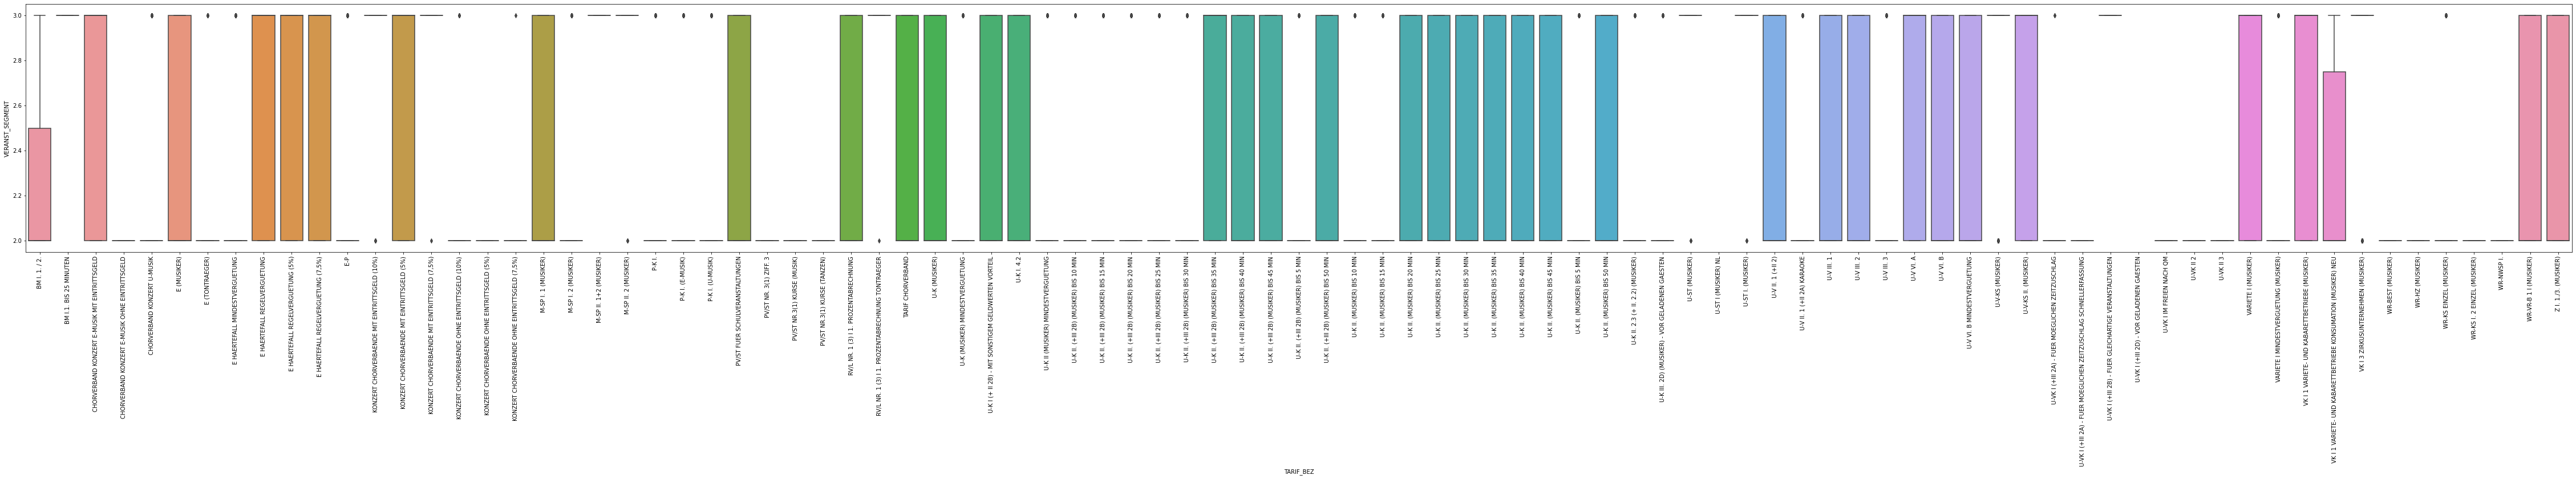

In [18]:
# sns.barplot(x=lowerclaim_df['TARIF_BEZ'], y=df['VERANST_SEGMENT'])
# plt.show()
#box plot Tarif/Customer Segment
data = pd.concat([lowerclaim_df['TARIF_BEZ'], df['VERANST_SEGMENT']], axis=1)
f, ax = plt.subplots(figsize=(80, 8))
fig = sns.boxplot(x="TARIF_BEZ", y="VERANST_SEGMENT", data=data)
# fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90)

In [22]:
# Find the relationship between tarif, customer segment and the band that performed
sns.boxplot(x="TARIF_BEZ", y="VERANST_SEGMENT", hue="BAND", data=lowerclaim_df);

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002090A438430> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# Find the relationship between tarif, customer segment and the location the event was performed
sns.boxplot(x="TARIF_BEZ", y="VERANST_SEGMENT", hue="LOCATION", data=lowerclaim_df);

Relationship with features

Correlation

In [14]:
# Find correlation of customer segments and other variables
lowerclaim_df.corr()['VERANST_SEGMENT'].sort_values(ascending=False)

VERANST_SEGMENT                  1.000000
VG_INKASSO                       0.875554
TARIF_NR                         0.159714
IMP_ID                           0.016941
GJ                               0.013378
NUTZLIZNEHM_GESCHAEFTSZEICHEN    0.000163
NUTZFALL                        -0.008144
NUTZFALL_NR                     -0.008580
BARCODE_NR                      -0.025598
VERANST_GESCHAEFTSZEICHEN       -0.035554
INKASSO_NETTO                         NaN
INKASSO_BRUTTO                        NaN
Name: VERANST_SEGMENT, dtype: float64

In [15]:
# Find correlation of VG_INKASSO and other variables
lowerclaim_df.corr()['VG_INKASSO'].sort_values(ascending=False)

VG_INKASSO                       1.000000
VERANST_SEGMENT                  0.875554
TARIF_NR                         0.212431
IMP_ID                           0.016038
GJ                               0.011671
NUTZLIZNEHM_GESCHAEFTSZEICHEN    0.000364
VERANST_GESCHAEFTSZEICHEN       -0.008584
NUTZFALL                        -0.012449
NUTZFALL_NR                     -0.016409
BARCODE_NR                      -0.029079
INKASSO_NETTO                         NaN
INKASSO_BRUTTO                        NaN
Name: VG_INKASSO, dtype: float64

In [20]:
lowerclaim_df.corr()

,IMP_ID,GJ,BARCODE_NR,VERANST_SEGMENT,NUTZFALL,TARIF_NR,NUTZFALL_NR,VG_INKASSO,INKASSO_NETTO,INKASSO_BRUTTO,VERANST_GESCHAEFTSZEICHEN,NUTZLIZNEHM_GESCHAEFTSZEICHEN
IMP_ID,1.000000,0.964368,0.536276,0.016941,0.657783,0.122436,0.636492,0.016038,1.0,1.0,0.105915,-0.054460
GJ,0.964368,1.000000,0.555722,0.013378,0.681507,0.121176,0.632508,0.011671,1.0,1.0,0.108989,-0.056110
BARCODE_NR,0.536276,0.555722,1.000000,-0.025598,0.771853,0.123917,0.670264,-0.029079,NaN,NaN,0.134637,-0.043295
VERANST_SEGMENT,0.016941,0.013378,-0.025598,1.000000,-0.008144,0.159714,-0.008580,0.875554,NaN,NaN,-0.035554,0.000163
NUTZFALL,0.657783,0.681507,0.771853,-0.008144,1.000000,0.157929,0.794169,-0.012449,NaN,NaN,0.127927,-0.053422
TARIF_NR,0.122436,0.121176,0.123917,0.159714,0.157929,1.000000,0.090901,0.212431,NaN,NaN,0.036866,0.002456
NUTZFALL_NR,0.636492,0.632508,0.670264,-0.008580,0.794169,0.090901,1.000000,-0.016409,NaN,NaN,0.130120,-0.062058
VG_INKASSO,0.016038,0.011671,-0.029079,0.875554,-0.012449,0.212431,-0.016409,1.000000,NaN,NaN,-0.008584,0.000364
INKASSO_NETTO,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
INKASSO_BRUTTO,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN


<AxesSubplot:>

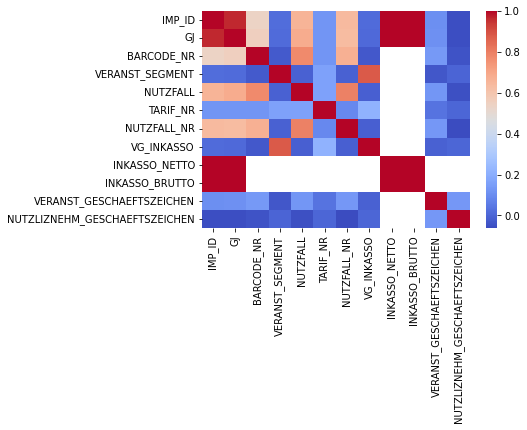

In [21]:
sns.heatmap(lowerclaim_df.corr(), cmap='coolwarm')

Outliers